In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import MeanAbsolutePercentageError
from torch.utils.data import DataLoader, TensorDataset

from data.dataloader import dl_from_numpy, dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config

from models.predictor import GRU
from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel
from models.solver import train_prediction_model, evaluate_model

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_adv.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Diffusion_TS Model
diffusion_ts = instantiate_from_config(configs['gen_model']).to(device)


In [3]:
# dataloader
dl_info = dataloader_info(configs)
dataset = dl_info['dataset']

In [4]:
# load pretrained model
try:
    diffusion_ts.load_state_dict(torch.load("check_points/stock/gen_24/model_5000.pth"))
    
except:
    trainer = Trainer(config_solver=configs["gen_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
    trainer.train_decomp()

In [6]:
# generate multivariate time-series
# fake_data = diffusion_ts.generate_mts(batch_size=3000)
# np.save(os.path.join(dataset.dir, f'ddpm_fake_stock.npy'), fake_data)

reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 500/500 [02:24<00:00,  3.45it/s]


In [5]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
ori_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))
idx = np.random.permutation(len(ori_data))[:3000]
ori_data = ori_data[idx]

# load fake data
fake_data = np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))


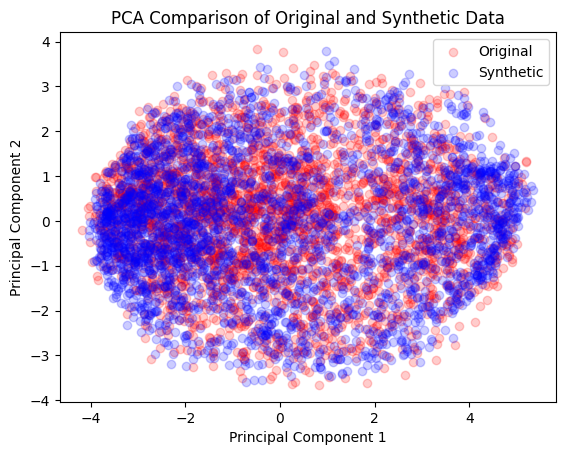

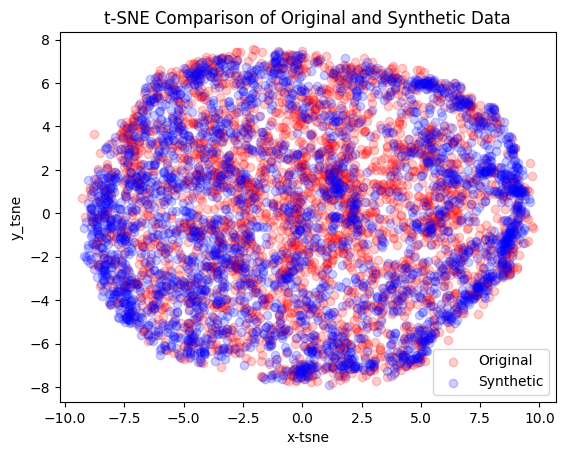

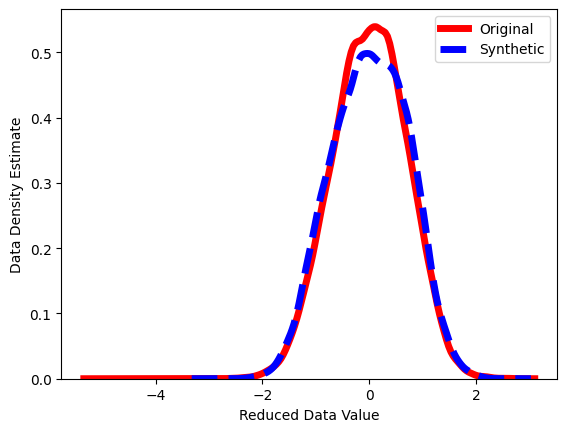

In [6]:
# PCA Analysis
visualize_pca(ori_data, fake_data, n_sample=3000)
visualize_tsne(ori_data, fake_data, n_sample=3000)
visualize_kernel(ori_data, fake_data, n_sample=3000)

In [7]:
# models
ori_model = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
fake_model = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)

# loss function
lossfn = nn.L1Loss()

# optimizer
lr = 0.001
batch_size = 128
optimizer_ori = optim.Adam(ori_model.parameters(), lr=lr)
optimizer_fake = optim.Adam(fake_model.parameters(), lr=lr)


In [8]:
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)

In [9]:
train_prediction_model(ori_model, ori_dl, lossfn, optimizer_ori, device=device, epochs=1000, description="Original")
train_prediction_model(fake_model, fake_dl, lossfn, optimizer_fake, device=device, epochs=1000, description="Synthetic")

Synthetic loss: 0.018250:  64%|██████▍   | 1290/2000 [00:28<00:15, 45.80it/s]

In [ ]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

ori_l1, ori_l2, mape_ori, pred_y_ori, true_y = evaluate_model(ori_model, test_loader)
fake_l1, fake_l2, mape_fake, pred_y_fake, _ = evaluate_model(fake_model, test_loader)

print(f"Original Model : \t L1 loss: {ori_l1:0.5f} \t L2 Loss : {ori_l2:0.5f} \t MAPE loss : {mape_ori:0.5f} ")
print(f"Fake Model : \t L1 loss: {fake_l1:0.5f} \t L2 Loss : {fake_l2:0.5f} \t MAPE loss : {mape_fake:0.5f} ")


NameError: name 'evaluate_model' is not defined

In [6]:
diffusion_ts.train_predictor(dl_info["dataloader"],device, num_epochs=2000)

Pretraining predictor loss: 0.070764:  17%|█▋        | 335/2000 [00:07<00:38, 42.80it/s]


KeyboardInterrupt: 